# WeatherPy

CONSOLIDATED THE CITIPY AND OPENWEATHER LOGIC

In [16]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import requests
import json
from pprint import pprint
from datetime import datetime

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

#Set todays date to include in plots
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y")


## Generate Cities List and dataframe

- Generate 1500 random latitude and longitude pairs
- Use citypy to find the cities nearest those lat/long coordinates. Note this may result in the same city being nearest to more than one of the lat/long coords. In this case the city is ignored. So the final list of cities may be fewerr than the number of random lat/long coords generated.
- Output is a list of cities with their country and the lat/long coords that produced that city from citipy. Note that these lat/long coords are not the actual lat/long coords of the city on a map. These will be found from the OpenWeather API in the nest step.

In [17]:
#Initialize empty lists for: Lat/Lng pairs, cities, countries, latitude, and longitude (the original pairs used to find the "nearest city"). Note this is NOT the actual lat/lng of the city, this is captured later from the OpenWeather API

#Reinitialize lists to null
cities = []
countries=[]
orig_latitude=[]
orig_longitude=[]
city_ID=[]
city_temp=[]
city_humidity=[]
city_clouds_pct=[]
city_windspeed=[]
city_latitude=[]
city_longitude=[]

#How many cities do you want to plot?
target_city_count = 501

#Set counter to test if we have found the requested number of cities that are in citypy, OpenWeather, and with humidity<=100
big_city_count = 0
while big_city_count<target_city_count:
    #Get a random lat long coordinate
    lats = np.random.uniform(lat_range[0], lat_range[1])
    lngs = np.random.uniform(lng_range[0], lng_range[1])
    #Get the nearest city and it's country from citipy
    city = citipy.nearest_city(lats, lngs).city_name
    country = citipy.nearest_city(lats, lngs).country_code
    #Create the OpenWeather url using the city and country from citypy and my personal weather api key
    url = 'http://api.openweathermap.org/data/2.5/weather?q='+city+',,'+country+'&units=imperial&appid='+weather_api_key
    #Get the response from OpenWeather API
    res = requests.get(url)
    #If response is 200 then OpenWeather has data on this city so proceed to read json data add the city to the df
    if res.status_code == 200:
        response = res.json()
        #Check for humidity not over 100 as per instructions
        if response['main']['humidity']<=100:
            #Append all the necessary data to lists
            cities.append(city)
            countries.append(country)
            orig_latitude.append(lats)
            orig_longitude.append(lngs)
            city_ID.append(response['id'])
            city_temp.append(response['main']['temp'])
            city_humidity.append(response['main']['humidity'])
            city_clouds_pct.append(response['clouds']['all'])
            city_windspeed.append(response['wind']['speed'])
            city_latitude.append(response['coord']['lat'])
            city_longitude.append(response['coord']['lon'])
            big_city_count += 1

#Create the city df that has the exact number of desired cities with no city with humidity >100
city_data = pd.DataFrame(columns=['City ID', 'City', 'Country', 'Orig Lat', 'Orig Lon', 'Act Lat', 'Act Lon', 'Temperature (F)', 'Humidity', 'Cloudiness', 'Wind Speed'])

#Add the lists from the loops to the df
city_data['City ID'] = city_ID
city_data['City'] = cities
city_data['Country'] = countries
city_data['Orig Lat'] = orig_latitude
city_data['Orig Lon'] = orig_longitude
city_data['Act Lat'] = city_latitude
city_data['Act Lon'] = city_longitude
city_data['Temperature (F)'] = city_temp
city_data['Humidity'] = city_humidity
city_data['Cloudiness'] = city_clouds_pct
city_data['Wind Speed'] = city_windspeed

#Set df index to the unique city ID from OpenWeather API
city_data.set_index('City ID', inplace=True)

#Clean up by deleting columns not needed for plot. Delete the original lat and long since they are not the actual lat and long of the city itself.
del city_data['Orig Lat']
del city_data['Orig Lon']

#Create the northern and southern hemisphere splits of the city df
north_city_data = city_data.loc[city_data['Act Lat']>=0]
south_city_data = city_data.loc[city_data['Act Lat']<0]

#Control check output
print('The total number of cities added is '+str(len(city_data)))
print(city_data.head())

#Export the City_Data and Clean_city_data into csv's
city_data.to_csv(output_data_file)


The total number of cities added is 501
               City Country  Act Lat  Act Lon  Temperature (F)  Humidity  \
City ID                                                                    
508441     poddorye      ru    57.47    31.12            49.66        64   
2126199    cherskiy      ru    68.75   161.30             7.21        95   
3421765  nanortalik      gl    60.14   -45.24            28.27        89   
5882953     aklavik      ca    68.22  -135.01            17.20        48   
2189343        kaeo      nz   -35.10   173.78            65.52        83   

         Cloudiness  Wind Speed  
City ID                          
508441           38       10.18  
2126199         100       13.38  
3421765          86        1.59  
5882953          75        6.93  
2189343         100        3.00  


## Plotting the Data and Linear Regression
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

##Function to return scatter plot and optional linear regression plat and file path/name for saving

In [18]:
def get_line(x,y,x_name,y_name, incl_regress):
    
    ax1=[]
    ax2=[]
    city_count = x.count()
    ax1=plt.scatter(x,y)
    ax1=plt.title(f'{city_count} cities on {timestampStr}: {y_name} vs. {x_name}')
    ax1=plt.xlabel(x_name)
    ax1=plt.ylabel(f'{y_name}')

    if incl_regress:
        slope, intercept, rvalue, pvalue, stderr = st.linregress(x,y)
        r_squared = rvalue**2
        ax2=plt.plot(x, x*slope+intercept, color='red', label= 'Y= '+str(round(slope,2))+'*X + '+str(round(intercept,2))+' R2='+str(round(r_squared,2)))
        ax2=plt.legend()
    if min(x)<0:
        if max(x)>0:
            hem='Global'
            ax1 = plt.xlim(-60, 90)
        else:
            hem='South'
            ax1 = plt.xlim(-60, 0)
    else:
        hem='North'
        ax = plt.xlim(0,90)
    
    png_file = 'output_data/'+y_name+'_'+x_name+'_'+hem+'.png'

    return ax1, ax2, png_file

## Latitude vs. Temperature Plot

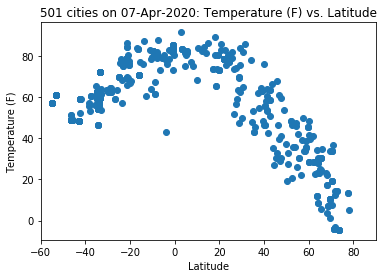

In [19]:
graph1, graph2, png_file = get_line(city_data['Act Lat'], city_data['Temperature (F)'], 'Latitude', 'Temperature (F)', False)
plt.savefig(png_file)
plt.show()

## Latitude vs. Humidity Plot

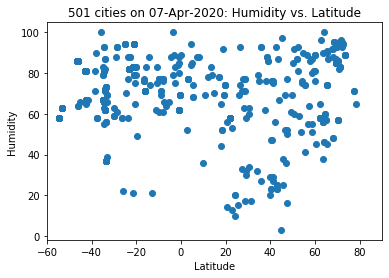

In [20]:
graph1, graph2, png_file = get_line(city_data['Act Lat'], city_data['Humidity'], 'Latitude', 'Humidity', False)
plt.savefig(png_file)
plt.show()

## Latitude vs. Cloudiness Plot

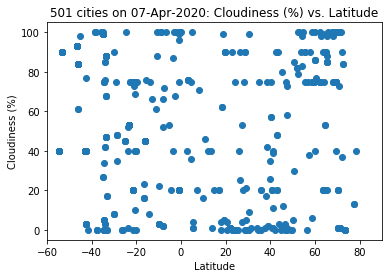

In [21]:
graph1, graph2, png_file = get_line(city_data['Act Lat'], city_data['Cloudiness'], 'Latitude', 'Cloudiness (%)', False)
plt.savefig(png_file)
plt.show()

## Latitude vs. Wind Speed Plot

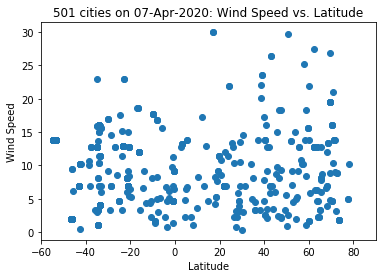

In [22]:
graph1, graph2, png_file = get_line(city_data['Act Lat'], city_data['Wind Speed'], 'Latitude', 'Wind Speed', False)
plt.savefig(png_file)
plt.show()

## Northern Hemisphere - Latitude vs. Temperature Plot 

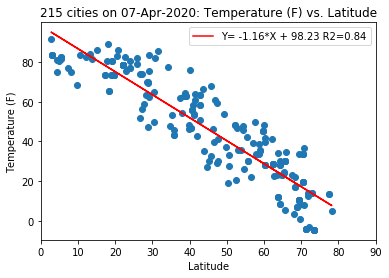

In [23]:
graph1, graph2, png_file = get_line(north_city_data['Act Lat'], north_city_data['Temperature (F)'], 'Latitude', 'Temperature (F)', True)
plt.savefig(png_file)
plt.show()

## Southern Hemisphere - Latitude vs. Temperature Plot 

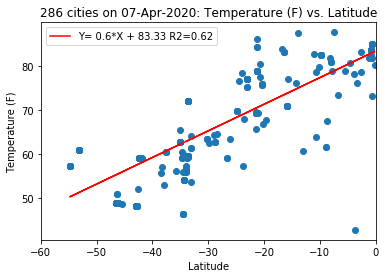

In [24]:
graph1, graph2, png_file = get_line(south_city_data['Act Lat'], south_city_data['Temperature (F)'], 'Latitude', 'Temperature (F)', True)
plt.savefig(png_file)
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

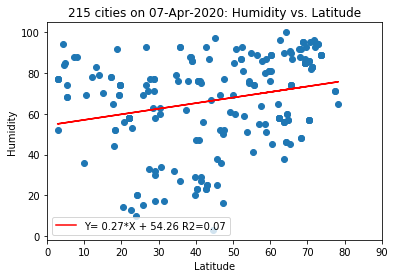

In [25]:
graph1, graph2, png_file = get_line(north_city_data['Act Lat'], north_city_data['Humidity'], 'Latitude', 'Humidity', True)
plt.savefig(png_file)
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

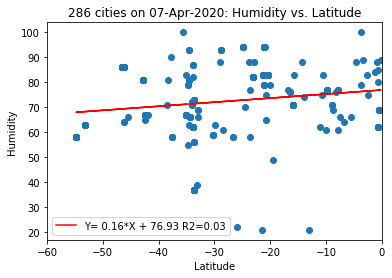

In [26]:
graph1, graph2, png_file = get_line(south_city_data['Act Lat'], south_city_data['Humidity'], 'Latitude', 'Humidity', True)
plt.savefig(png_file)
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

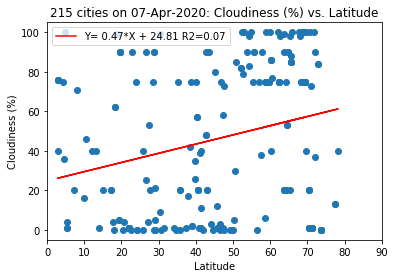

In [27]:
graph1, graph2, png_file = get_line(north_city_data['Act Lat'], north_city_data['Cloudiness'], 'Latitude', 'Cloudiness (%)', True)
plt.savefig(png_file)
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

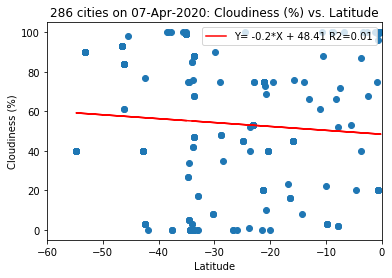

In [28]:
graph1, graph2, png_file = get_line(south_city_data['Act Lat'], south_city_data['Cloudiness'], 'Latitude', 'Cloudiness (%)', True)
plt.savefig(png_file)
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

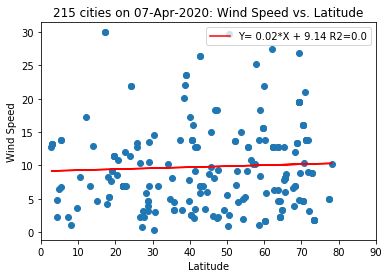

In [29]:
graph1, graph2, png_file = get_line(north_city_data['Act Lat'], north_city_data['Wind Speed'], 'Latitude', 'Wind Speed', True)
plt.savefig(png_file)
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

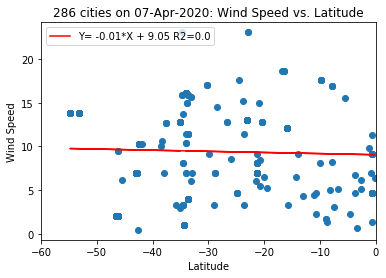

In [30]:
graph1, graph2, png_file = get_line(south_city_data['Act Lat'], south_city_data['Wind Speed'], 'Latitude', 'Wind Speed', True)
plt.savefig(png_file)
plt.show()